In [7]:
import sys
sys.path.insert(0, '../gambit')

import os
import numpy as np
import itertools

from gambit import create_diff_per_image, clean_data
from mask import create_segmentation_masks
from fits import read_fits, view_fits, write_fits

In [8]:
bands_in_order = ['g','r','i','z','y']

In [9]:
path_to_input = "/Users/cora-at-work/Desktop/github/spin-parity-catalog/original/galaxies/"
foreground_output_path = "/Users/cora-at-work/Desktop/research/winter_2023/foreground"
diff_per_output_path = "/Users/cora-at-work/Desktop/research/winter_2023/per_diff"

table_key = "table4"

def get_galaxy_list():
    return os.listdir(os.path.join(path_to_input,table_key))

def fits_path(name,band):
    return os.path.join(path_to_input,table_key,name,"{}_{}.fits".format(name,band))

def get_diff_per_path(name,first,base):
    return os.path.join(diff_per_output_path,table_key,"{}_diff_per_{}-{}.fits".format(name,first,base))

def get_foreground_path(name,base):
    return os.path.join(foreground_output_path,table_key,"{}_foreground_{}.fits".format(name,base))

In [10]:
from scipy import ndimage
import matplotlib.pyplot as plt

def get_key(first,base):
    return "{}-{}".format(first,base)

def bands_from_keys(the_key):
    to_parse = the_key.strip().split("-")
    return (to_parse[0],to_parse[1])

def calculate_center_of_mass(the_mask):
    return ndimage.center_of_mass(the_mask)

def get_cms(diff_per,foreground):
    thresholds = []
    above_threshold_cm = []
    below_threshold_cm = []
    
    m, s = np.mean(diff_per[foreground]), np.std(diff_per[foreground])
    
    for i in np.linspace(m-1*s,m+1*s):
        above_area = np.logical_and(foreground,diff_per>=i)
        below_area = np.logical_and(foreground,diff_per<i)
        
        thresholds.append(i)
        above_threshold_cm.append(calculate_center_of_mass(above_area))
        below_threshold_cm.append(calculate_center_of_mass(below_area))
        
    return (thresholds,above_threshold_cm,below_threshold_cm)
    
from scipy.spatial import distance

def constuct_diff_percentile_visualization(name,diff_pers_dict,foreground_dict):
    #print(diff_pers_dict.keys())
    #dst = distance.euclidean(np.asarray(t), np.asarray([0,0]))
    #super_foreground = np.ones(foreground_dict['r'].shape).astype('bool')
    #for band in foreground_dict:
    #    super_foreground = np.logical_and(super_foreground,foreground_dict[band])
    for band_pair_key in diff_pers_dict:
        print(band_pair_key)
        (first,base) = bands_from_keys(band_pair_key)
        (ts,a_cms,b_cms) = get_cms(diff_pers_dict[band_pair_key],foreground_dict[base])
        #(ts,a_cms,b_cms) = get_cms(diff_pers_dict[band_pair_key],super_foreground)
        a_points = np.asarray(a_cms)
        b_points = np.asarray(b_cms)
        #print(a_points[:,0],a_points[:,1])
        c = calculate_center_of_mass(foreground_dict[base])
        plt.imshow(diff_pers_dict[band_pair_key], interpolation='nearest', cmap='gray', origin='lower')
        plt.plot(a_points[:,0],a_points[:,1],color="blue") #break down above x,and y 
        plt.plot(b_points[:,0],b_points[:,1],color="red") #break down below x,and y
        plt.plot((a_points[:,0]+b_points[:,0])/2,(a_points[:,1]+b_points[:,1])/2,color="orange") #break down above x,and y 
        plt.plot(c[0],c[1],marker='v',color='green')
        
        #plt.plot(b_points[:,0],b_points[:,1],color="red") #break down below x,and y
        plt.show()
        #break

In [11]:
def construct_diff_percentile(name,first_band,base_band):
    first_band_path = fits_path(name,first_band)
    base_band_path = fits_path(name,base_band)
    
    if not (os.path.exists(first_band_path) and os.path.exists(base_band_path)): 
        print("path does not exist gaurd")
        return None

    first_band_data = clean_data(read_fits(first_band_path)) #added clean to handle infs/ nans
    base_band_data = clean_data(read_fits(base_band_path)) #added clean to handle infs/ nans
    
    if first_band_data.shape != base_band_data.shape: 
        print("shape issue gaurd")
        return None
    
    (foreground,_) = create_segmentation_masks(base_band_data)
    
    if np.sum(foreground) <= 0.01*np.sum(np.shape(base_band_data)): 
        print("small forground gaurd")
        return None
    
    #return create_diff_per_image(first_band_data,base_band_data,foreground)
    diff = create_diff_per_image(first_band_data,base_band_data,foreground)
    
    xu = []
    yu = []
    
    xl = []
    yl = []
    
    m, s = np.mean(diff[foreground]), np.std(diff[foreground])
    
    #for i in np.linspace(-0.8485599686033909,0.767479666014971,100):
    #for i in np.linspace(-0.5,0.5,10):
    #for i in [0,0.1]:
    #for i in np.linspace(m-3*s,m+3*s):
    #for i in np.linspace(-0.5,0.5,50):
    print(m-3*s,m+3*s)
    for i in np.linspace(m-1*s,m+1*s):
        upper_clip = np.logical_and(foreground,diff>=i)
        lower_clip = np.logical_and(foreground,diff<i)
        #view_fits(upper_clip)
        #view_fits(lower_clip)
        u_cm = calculate_center_of_mass(upper_clip)
        l_cm = calculate_center_of_mass(lower_clip)
        #d = (((u_cm[0]-l_cm[0])*(u_cm[0]-l_cm[0])) + ((u_cm[1]-l_cm[1])*(u_cm[1]-l_cm[1])))**0.5
        #print(i,d,u_cm,l_cm)
        xu.append(u_cm[0]);yu.append(u_cm[1]);
        xl.append(l_cm[0]);yl.append(l_cm[1])
        
    fig, ax = plt.subplots(figsize=(30,20))
    im = ax.imshow(diff, interpolation='nearest', cmap='gray', origin='lower')
    ax.plot(calculate_center_of_mass(foreground)[0],calculate_center_of_mass(foreground)[1], marker='v',color='green')
    ax.plot(xu, yu, color="blue", linewidth=3, alpha=0.2)
    ax.plot(xl, yl, color="red", linewidth=3, alpha=0.2)
    plt.show()
    #print(np.min(diff),np.max(diff))
    #view_fits(diff)
    #view_fits(foreground)
    #print(calculate_center_of_mass(foreground))
    return diff

1 NGC4800
g-r


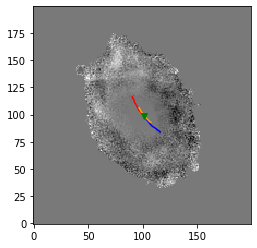

g-i


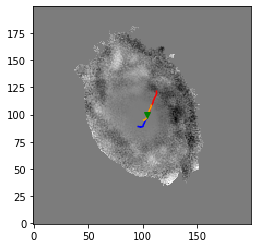

g-z


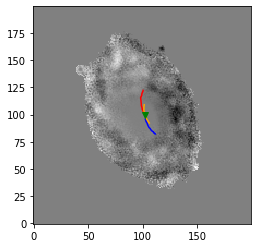

g-y


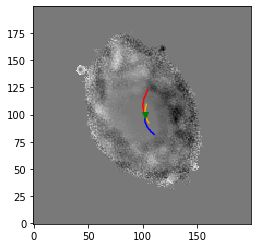

r-i


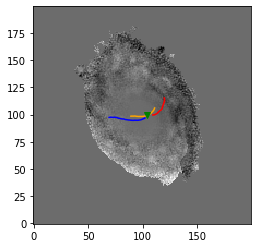

r-z


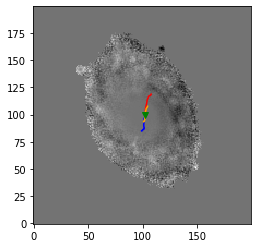

r-y


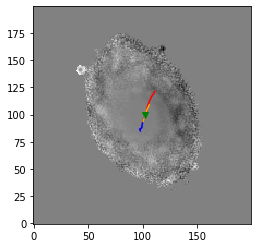

i-z


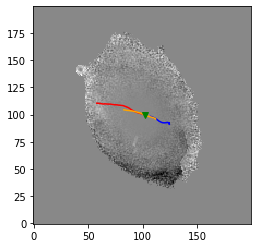

i-y


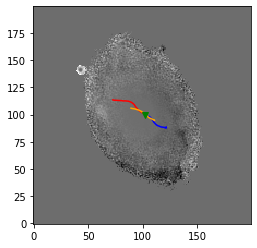

z-y


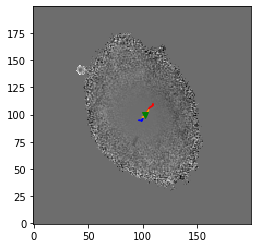

In [12]:
i = 1
for name in get_galaxy_list():
    name = 'NGC4800'
    print(i,name)
    diff_pers_dict = {}
    foreground_dict = {}
    for (first_band,base_band) in itertools.combinations(bands_in_order, 2):
        diff_path = get_diff_per_path(name,first_band,base_band)
        
        if not os.path.exists(diff_path): 
            continue
        
        diff_pers_dict[get_key(first_band,base_band)] = read_fits(diff_path)
        
        if base_band in foreground_dict or not os.path.exists(get_foreground_path(name,base_band)):
            continue
        
        foreground_dict[base_band] = read_fits(get_foreground_path(name,base_band)).astype('bool')

    constuct_diff_percentile_visualization(name,diff_pers_dict,foreground_dict)
    i += 1
    if i > 10:
        break
    break